In [1]:
import statistics
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_vote_average = pd.read_csv("~/Documents/GR5291Project/Data/cleaned_movie_data_vote_average.csv")

In [3]:
y_vote_average = df_vote_average[df_vote_average.columns[0]]
X_vote_average = df_vote_average[df_vote_average.columns[1:len(y_vote_average)+1]]

In [4]:
# split data into training data 75%, test data 25%
seed = 123
test_size = 0.25
X_vote_average_train, X_vote_average_test, y_vote_average_train, y_vote_average_test = train_test_split(X_vote_average, y_vote_average, test_size=test_size, random_state=seed)

In [11]:
# tune parameters
model = XGBRegressor()
n_estimators = [50, 100, 150, 200]
max_depth = [3, 5, 7, 9, 11]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", cv=5, n_jobs = -1)
grid_result = grid_search.fit(X_vote_average_train, y_vote_average_train)

In [12]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.330397 using {'max_depth': 3, 'n_estimators': 200}


-0.355161 (0.009155) with: {'max_depth': 3, 'n_estimators': 50}
-0.332336 (0.010806) with: {'max_depth': 3, 'n_estimators': 100}
-0.330565 (0.012440) with: {'max_depth': 3, 'n_estimators': 150}
-0.330397 (0.014936) with: {'max_depth': 3, 'n_estimators': 200}
-0.341726 (0.007355) with: {'max_depth': 5, 'n_estimators': 50}
-0.335832 (0.012220) with: {'max_depth': 5, 'n_estimators': 100}
-0.340906 (0.013711) with: {'max_depth': 5, 'n_estimators': 150}
-0.345850 (0.013688) with: {'max_depth': 5, 'n_estimators': 200}
-0.341120 (0.014217) with: {'max_depth': 7, 'n_estimators': 50}
-0.338869 (0.014014) with: {'max_depth': 7, 'n_estimators': 100}
-0.343732 (0.016053) with: {'max_depth': 7, 'n_estimators': 150}
-0.347880 (0.016987) with: {'max_depth': 7, 'n_estimators': 200}
-0.349285 (0.013107) with: {'max_depth': 9, 'n_estimators': 50}
-0.353260 (0.010956) with: {'max_depth': 9, 'n_estimators': 100}
-0.356103 (0.010429) with: {'max_depth': 9, 'n_estimators': 150}
-0.358766 (0.011312) with: {'

Text(0,0.5,'MAE')

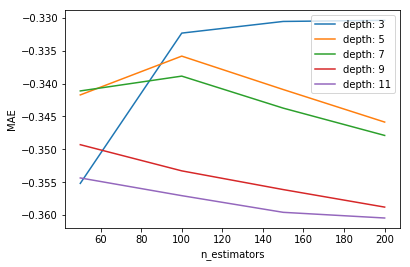

In [13]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('MAE')

In [5]:
#fit best model
best_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [7]:
# training error of best model(MAPE)
best_model.fit(X_vote_average_train, y_vote_average_train)
y_vote_average_pred_train = best_model.predict(X_vote_average_train)
statistics.mean(abs((y_vote_average_pred_train-y_vote_average_train)/y_vote_average_train))

0.059022925814498584

In [8]:
# R-square
best_model.score(X_vote_average_train, y_vote_average_train)

0.70574952112143308

In [9]:
# test error of best model(MAPE)
best_model.fit(X_vote_average_train, y_vote_average_train)
y_vote_average_pred = best_model.predict(X_vote_average_test)
statistics.mean(abs((y_vote_average_pred-y_vote_average_test)/y_vote_average_test))

0.078309812225492645

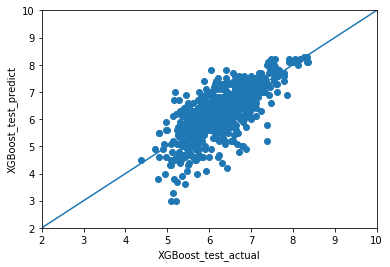

In [25]:
#plot the predicted values against the actual values
plt.scatter(x=y_vote_average_pred, y=y_vote_average_test)
plt.xlim([2,10])
plt.ylim([2,10])
plt.plot([2,10],[2,10])
plt.xlabel('XGBoost_test_actual')
plt.ylabel('XGBoost_test_predict')
plt.show()

In [76]:
# Interpreting the model
feature_import = pd.DataFrame(data=best_model.feature_importances_, index=X_vote_average.columns.values, columns=['values'])
feature_import.sort_values(['values'], ascending=False, inplace=True)
feature_import.transpose()

,vote_count,year,runtime,month,minority_studios,majority_studios,Animation,Action,Drama,Science.Fiction,...,L27,L52,L4,L50,L32,L10,L54,L6,Foreign,L14
values,0.263554,0.136295,0.125753,0.060241,0.044428,0.039157,0.026355,0.026355,0.024096,0.021837,...,0.003765,0.003012,0.003012,0.000753,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
feature_import.iloc[0:15,:]

,values
vote_count,0.263554
year,0.136295
runtime,0.125753
month,0.060241
minority_studios,0.044428
majority_studios,0.039157
Animation,0.026355
Action,0.026355
Drama,0.024096
Science.Fiction,0.021837


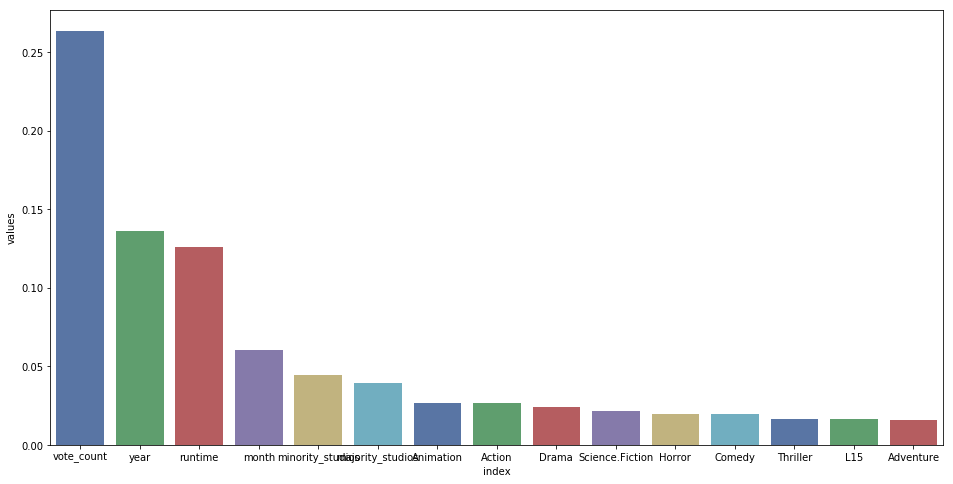

In [78]:
plt.figure(figsize=(16,8))
feature_import=feature_import.iloc[0:15,:]
feature_import.reset_index(level=0, inplace=True)
sns.barplot(x='index', y='values', data=feature_import, palette='deep')
plt.show()

# source: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/